In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("mps")

In [3]:
class MLPBlock(nn.Module):
    def __init__(self, hidden_size=64, num_layers=3, dropout_prob=0.5):
        super(MLPBlock, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_prob))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class NCLNetwork(nn.Module):
    def __init__(self, input_size=2, output_size=1, num_blocks=10, hidden_size=64, num_layers=3, dropout_prob=0.5):
        super(NCLNetwork, self).__init__()
        blocks = []
        for _ in range(num_blocks):
            blocks.append(MLPBlock(hidden_size, num_layers, dropout_prob))
            blocks.append(nn.BatchNorm1d(hidden_size))
            blocks.append(nn.Dropout(p=dropout_prob))
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.blocks = nn.Sequential(*blocks)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

#Model Parameters
input_size = 2
output_size = 1
num_blocks = 10
hidden_size = 64
num_layers = 3
dropout_prob = 0.5

model = NCLNetwork(input_size, output_size, num_blocks, hidden_size, num_layers, dropout_prob)
model.to(device)



NCLNetwork(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (blocks): Sequential(
    (0): MLPBlock(
      (network): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.5, inplace=False)
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): ReLU()
        (8): Dropout(p=0.5, inplace=False)
      )
    )
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): MLPBlock(
      (network): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.5, inplace=False)
        (6): Linear(in_f

In [4]:
class PhysicsInformedNN():
    def __init__(self, S, t, u, r, sigma):

        # data
        self.S = torch.tensor(S, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        # self.sigma = sigma
        # self.r = r

        # settings
        self.sigma = torch.tensor([sigma], requires_grad=True).to(device)
        self.r = torch.tensor([r], requires_grad=True).to(device)

        self.sigma = torch.nn.Parameter(self.sigma)
        self.r = torch.nn.Parameter(self.r)

        # dnn
        self.dnn = NCLNetwork(input_size, output_size, num_blocks, hidden_size, num_layers, dropout_prob).to(device)
        self.dnn.register_parameter('sigma', self.sigma)
        self.dnn.register_parameter('r', self.r)

        for m in self.dnn.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=0.001)
        self.iter = 0

    def net_u(self, S, t):
        u = self.dnn(torch.cat([S, t], dim=1))
        return u

    def net_f(self, S, t):
        sigma = self.sigma
        r = self.r
        u = self.net_u(S, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_s = torch.autograd.grad(
            u, S,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_ss = torch.autograd.grad(
            u_s, S,
            grad_outputs=torch.ones_like(u_s),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + 0.5 * sigma**2 * S**2 * u_ss + r * S * u_s - r * u
        return f

    def loss_func(self):
        u_pred = self.net_u(self.S, self.t)
        f_pred = self.net_f(self.S, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print('Loss: %e' %(loss.item()))
        return loss

    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.S, self.t)
            f_pred = self.net_f(self.S, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            if epoch % 100 == 0:
                print('It: %d, Loss: %.3e' %(epoch, loss.item()))


    def predict(self, S, t):
        S = torch.tensor(S, requires_grad=True).float().to(device)
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
# Methods to calculate the black scholes price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)

    N_d1 = 0.5 * (1 + torch.erf(d1 / math.sqrt(2)))
    N_d2 = 0.5 * (1 + torch.erf(d2 / math.sqrt(2)))

    call_price = S * N_d1 - K * torch.exp(-r * T) * N_d2
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)

    N_d1 = 0.5 * (1 + torch.erf(-d1 / math.sqrt(2)))
    N_d2 = 0.5 * (1 + torch.erf(-d2 / math.sqrt(2)))

    put_price = K * torch.exp(-r * T) * N_d2 - S * N_d1
    return put_price

In [6]:
# Define parameters
S_min = torch.tensor(126)
S_max = torch.tensor(182)
T = torch.tensor(2.3)
K = torch.tensor(160)
r = torch.tensor(0.05)
sigma = torch.tensor(0.2)
num_samples = 100

In [7]:
S_samples = torch.linspace(S_min, S_max, num_samples)
t_samples = torch.linspace(0.002, T, num_samples)
S_grid, t_grid = torch.meshgrid(S_samples, t_samples)
X_train = torch.stack([S_grid.flatten(), t_grid.flatten()], axis=1)
X_train.requires_grad = True

In [8]:
# Calculate call and put prices
call_price = black_scholes_call(S_grid.flatten(), K, t_grid.flatten(), r, sigma)
put_price = black_scholes_put(S_grid.flatten(), K, t_grid.flatten(), r, sigma)

print("Call Price:", call_price[-1])
print("Put Price:", put_price[0])

Call Price: tensor(45.1759)
Put Price: tensor(33.9840)


In [9]:
model = PhysicsInformedNN(S_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1), call_price, r, sigma)

In [11]:
model.train(1500)

It: 0, Loss: 1.240e+02
It: 100, Loss: 1.239e+02
It: 200, Loss: 1.238e+02
It: 300, Loss: 1.239e+02
It: 400, Loss: 1.238e+02
It: 500, Loss: 1.237e+02
It: 600, Loss: 1.238e+02
It: 700, Loss: 1.238e+02
It: 800, Loss: 1.238e+02
It: 900, Loss: 1.238e+02
It: 1000, Loss: 1.238e+02
It: 1100, Loss: 1.238e+02
It: 1200, Loss: 1.237e+02
It: 1300, Loss: 1.236e+02
It: 1400, Loss: 1.237e+02


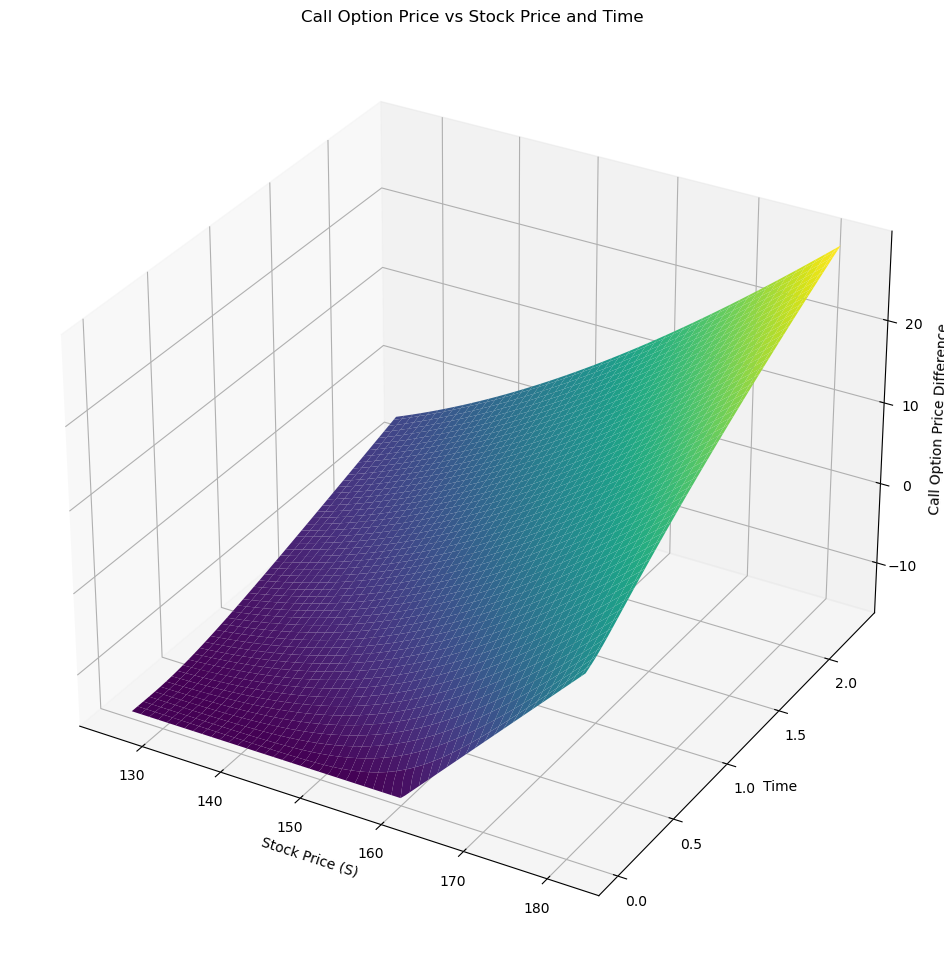

In [11]:
S_plot = torch.linspace(S_min, S_max, num_samples)
t_plot = torch.linspace(0, T, num_samples)
S_plot_grid, t_plot_grid = torch.meshgrid(S_plot, t_plot)
X_plot = torch.stack([S_plot_grid.flatten(), t_plot_grid.flatten()], axis=1)

u, f = model.predict(S_plot.flatten().unsqueeze(1), t_plot.flatten().unsqueeze(1))
call_price = black_scholes_call(S_plot_grid, K, t_plot_grid, r, sigma).detach().numpy()
diff = call_price - u

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(S_plot_grid, t_plot_grid, diff, cmap='viridis')

ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time')
ax.set_zlabel('Call Option Price Difference')
ax.set_title('Call Option Price vs Stock Price and Time')
plt.show()